In [1]:
import numpy as np
import extra_func as ext
import matplotlib.pyplot as plt
%load_ext xsimlab.ipython
from fastscape.models import basic_model
from adascape.fastscape_ext import IR12Speciation, FastscapeElevationTrait, CompoundEnvironment, ElevationEnvField, RandomSeedFederation
from fastscape.processes import Flexure
import xarray as xr

In [2]:
adaspec_IR12_model = basic_model.update_processes(
    {'life': IR12Speciation,
     'trait_elev': FastscapeElevationTrait,
     'life_env': CompoundEnvironment,
     'elev_field': ElevationEnvField,
     'random': RandomSeedFederation}
)
adaspec_IR12_model=adaspec_IR12_model.update_processes({'flexure': Flexure}).drop_processes({'init_topography'})

In [3]:
clk = np.linspace(0, 25e6, 1001)
nx, ny = 101, 201
lx, ly = 1e5, 2e5

xx, yy = np.meshgrid(np.linspace(0,lx, nx), np.linspace(0,ly,ny))
h0 = np.where((((xx - 5e4) / (2e4)) ** 2 + ((yy - 1e5) / (5e4)) ** 2 <= 1),1,0)
boundary = np.column_stack([xx[h0.astype('bool')], yy[h0.astype('bool')]])

h0 = xr.DataArray(h0, dims=('y', 'x'))

random_seed = 12345

In [4]:
boundary.shape

(3125, 2)

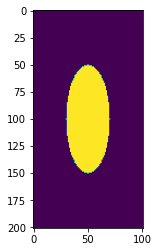

In [5]:
plt.imshow(h0)

In [6]:
# %create_setup adaspec_IR12_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=adaspec_IR12_model,
    clocks={'time':clk,
            'out':clk[::10]},
     master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny, nx],
        # total grid length in (y, x)
        'grid__length': [ly, lx],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 0,
        # bedrock channel incision coefficient
        'spl__k_coef': h0*2.5e-7,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 3e-2,
        # lithospheric rock density
        'flexure__lithos_density': 2600,
        # asthenospheric rock density
        'flexure__asthen_density': 3200,
        # effective elastic plate thickness
        'flexure__e_thickness': 5e4,
        # surface topography elevation
        'topography__elevation': (h0*1500) + np.random.random((ny, nx)),
        # min initial trait value
        'trait_elev__init_trait_min': 0.75,
        # max initial trait value
        'trait_elev__init_trait_max': 0.75,
        # slope of opt. trait vs. elevation linear relationship
        'trait_elev__lin_slope': 0.95,
        # min elevation value for normalization
        'trait_elev__norm_min': 1,
        # max elevation value for normalization
        'trait_elev__norm_max': 1500,
        # initial number of individuals
        'life__init_abundance': 100,
        # random number generator seed
        'life__random_seed': random_seed,
        # threshold used to construct taxon clusters
        'life__taxon_threshold': 0.05,
        # Taxon definition based on common ancestry and traits ('traits') or common ancestry,
        # traits and location ('traits_location')
        'life__taxon_def': 'traits',
        # min range of individuals on x coordinate
        'life__init_x_range_min':  0.35*lx,
        # min range of individuals on x coordinate
        'life__init_x_range_max':  0.45*lx,
        # min range of individuals on y coordinate
        'life__init_y_range_min':  0.35*ly,
        # min range of individuals on y coordinate
        'life__init_y_range_max':  0.65*ly,
        # dispersal boundary
        'life__disp_boundary': xr.DataArray(boundary, dims=('p', 'd')),
        # Correlation coefficient between traits, 0 means that traits are independent, where a
        # value of rho different from 0 and between -1 and 1, will determine the degree of
        # correlation betweentraits for all individuals
        'life__rho': 0,
        # trait mediated competition for a limiting resource, where the degree of trait
        # similarity is given by this parameter. If its value is =>1 all individuals in the
        # local neighbourhood are counted, but if its values is < 1 then only those
        # individuals with similar trait values are counted.
        'life__sigma_u': 0.2,
        # environmental fitness selectivity or width around optimal traitvalue for each
        # individual's trait
        'life__sigma_f': 0.2,
        # dispersal variability in spatial units
        'life__sigma_d': 10e3,
        # trait variability of mutated offspring
        'life__sigma_m': 0.05,
        # mutation probability
        'life__p_m': 0.005,
        # fixed neighborhood radius
        'life__r': 2.0e4,
        # carrying capacity within a neighborhood
        'life__K': 50,
        # random number generator seed
        'random__seed': random_seed,
    },
    output_vars={'topography__elevation': 'out',
                 'flow__basin': 'out',
                 'grid__cell_area': 'out',
                 'life__x': 'out',
                 'life__y': 'out',
                 'life__traits': 'out',
                 'life__taxon_id': 'out',
                 'life__ancestor_id': 'out'}
)

In [7]:
with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=adaspec_IR12_model)                   

             0% | initialize 

In [8]:
dtf = ext.get_dataframe(ds_out, out_vars=['life__taxon_id', 'life__ancestor_id',
                                'life__trait_elev', 'life__y', 'life__x'])

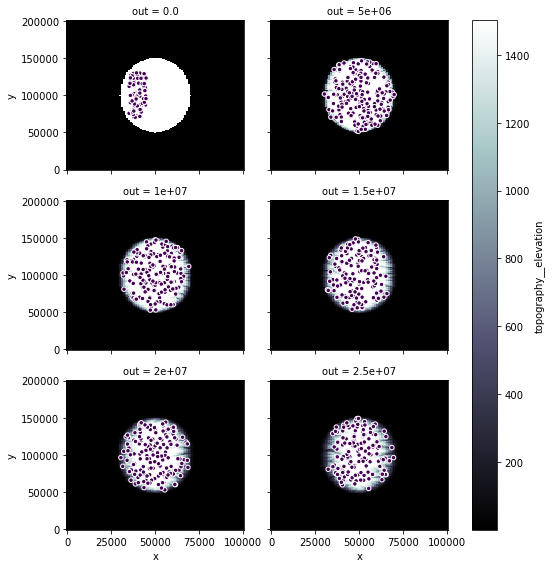

In [9]:
time_sel = np.arange(0,26e6, 5e6)
fg = (ds_out
      .sel(out=time_sel)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(8, 8), cmap='bone'))


for ax, t in zip(fg.axes.ravel(), time_sel):
    pop = dtf[dtf.out==t]
    ax.scatter(pop.x, pop.y, c=pop.taxon_id, s=20, edgecolor='w')